In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
file_path = '/content/drive/My Drive/Energy/data/test_data/daejeonall.xlsx'

df = pd.read_excel(file_path)

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
df

,USEYM,ELECUSEQTY,GASUSEQTY,CARBONQTY
0,201801,3980666097,7681306182,3518207759
1,201802,3840397126,8562619729,3647670763
2,201803,3584679739,7066011131,3200965755
3,201804,3521990392,4889837635,2693414316
4,201805,3483857350,2912675334,2240924145
...,...,...,...,...
62,202303,3668978714,5698985530,2938938697
63,202304,3640601710,3893754354,2528754423
64,202305,3660084776,2523074655,2236153651
65,202306,3820197364,1738219734,2137024946


In [4]:
df2 = df[['USEYM', 'ELECUSEQTY']]
df2

,USEYM,ELECUSEQTY
0,201801,3980666097
1,201802,3840397126
2,201803,3584679739
3,201804,3521990392
4,201805,3483857350
...,...,...
62,202303,3668978714
63,202304,3640601710
64,202305,3660084776
65,202306,3820197364


In [5]:
# USEYM 열을 년월 형식으로 변환
df2['USEYM'] = pd.to_datetime(df2['USEYM'], format='%Y%m')

# 년월을 인덱스로 설정
df2.set_index('USEYM', inplace=True)

# 데이터프레임 확인
print(df2.head())


            ELECUSEQTY
USEYM                 
2018-01-01  3980666097
2018-02-01  3840397126
2018-03-01  3584679739
2018-04-01  3521990392
2018-05-01  3483857350


<ipython-input-5-3c253c6619f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['USEYM'] = pd.to_datetime(df2['USEYM'], format='%Y%m')


# 모델

In [ ]:
df2

,ELECUSEQTY
USEYM,
2018-01-01,3980666097
2018-02-01,3840397126
2018-03-01,3584679739
2018-04-01,3521990392
2018-05-01,3483857350
...,...
2023-03-01,3668978714
2023-04-01,3640601710
2023-05-01,3660084776


In [6]:
import pandas as pd


df2['year'] = df2.index.year
df2['month'] = df2.index.month
df2['quarter'] = df2.index.quarter
df2['month_str'] = df2.index.strftime('%Y-%m')

df2

<ipython-input-6-f91b7b42ec54>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['year'] = df2.index.year
<ipython-input-6-f91b7b42ec54>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['month'] = df2.index.month


,ELECUSEQTY,year,month,quarter,month_str
USEYM,,,,,
2018-01-01,3980666097,2018,1,1,2018-01
2018-02-01,3840397126,2018,2,1,2018-02
2018-03-01,3584679739,2018,3,1,2018-03
2018-04-01,3521990392,2018,4,2,2018-04
2018-05-01,3483857350,2018,5,2,2018-05
...,...,...,...,...,...
2023-03-01,3668978714,2023,3,1,2023-03
2023-04-01,3640601710,2023,4,2,2023-04
2023-05-01,3660084776,2023,5,2,2023-05


<ipython-input-7-dfe771278a6a>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = model.predict(test_data[FEATURES])


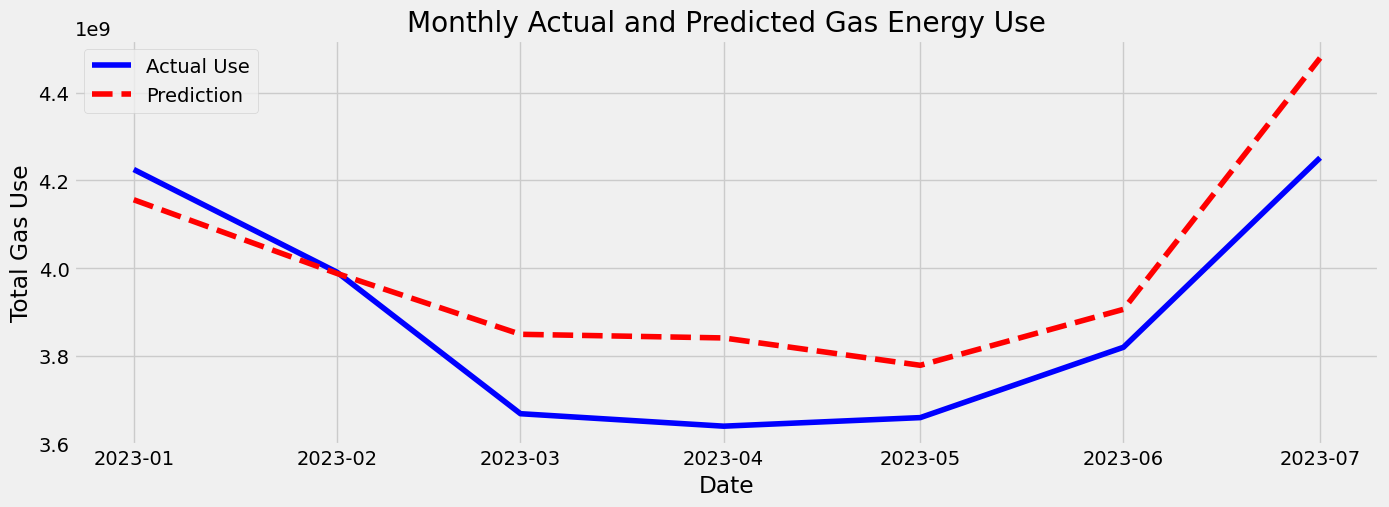

RMSE: 146842463.46
MAE: 126555680.86
R^2: 0.64
sMAPE: 0.03


In [7]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# 데이터를 월별로 집계
monthly_agg = df2.groupby(df2.index).agg({'ELECUSEQTY':'sum', 'year':'first', 'month':'first', 'quarter':'first'})

# 모델 훈련을 위한 특성과 타겟
FEATURES = ['year', 'month', 'quarter']
TARGET = 'ELECUSEQTY'

# 훈련 데이터와 테스트 데이터 분할
train_data = monthly_agg.loc[:'2022-12-31']
test_data = monthly_agg.loc['2023-01-01':'2023-07-31']

model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, objective='reg:squarederror', random_state=42)
model.fit(train_data[FEATURES], train_data[TARGET])

# 월별 예측을 수행
test_data['prediction'] = model.predict(test_data[FEATURES])

# 월별 실제 사용량과 예측값을 시각화
plt.figure(figsize=(15, 5))
plt.plot(test_data.index, test_data[TARGET], label='Actual Use', color='blue')
plt.plot(test_data.index, test_data['prediction'], label='Prediction', color='red', linestyle='--')
plt.legend()
plt.title('Monthly Actual and Predicted Gas Energy Use')
plt.xlabel('Date')
plt.ylabel('Total Gas Use')
plt.show()

# RMSE, MAE, R^2, sMAPE 계산
actual_values = test_data[TARGET].dropna()
predicted_values = test_data['prediction'].loc[actual_values.index]

rmse_value = np.sqrt(((actual_values - predicted_values) ** 2).mean())
mae_value = np.abs(actual_values - predicted_values).mean()
r2_value = 1 - (((actual_values - predicted_values) ** 2).sum() / ((actual_values - actual_values.mean()) ** 2).sum())
smape_value = (np.abs(actual_values - predicted_values) / ((np.abs(actual_values) + np.abs(predicted_values)) / 2)).mean()

print(f'RMSE: {rmse_value:.2f}')
print(f'MAE: {mae_value:.2f}')
print(f'R^2: {r2_value:.2f}')
print(f'sMAPE: {smape_value:.2f}')


<ipython-input-44-5c851f94a6f9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = model.predict(test_data[FEATURES])


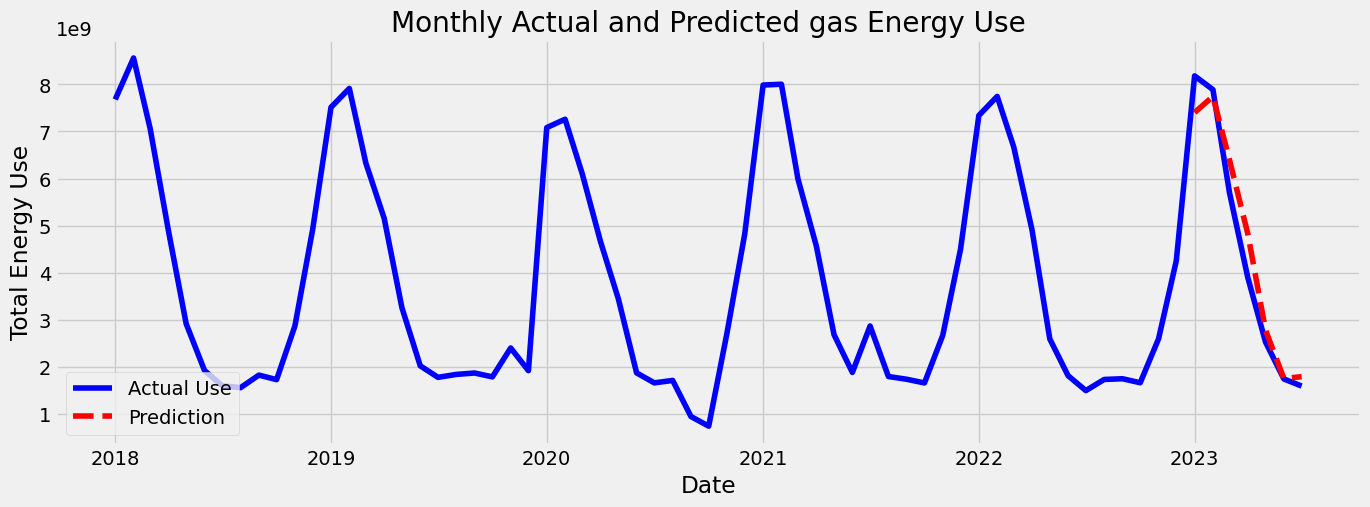

R^2: 0.96
sMAPE: 0.10


In [ ]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

# 데이터를 월별로 집계합니다.
monthly_agg = df2.groupby(df2.index).agg({'GASUSEQTY':'sum', 'year':'first', 'month':'first', 'quarter':'first'})

# 모델 훈련을 위한 특성과 타겟을 선택합니다.
FEATURES = ['year', 'month', 'quarter']
TARGET = 'GASUSEQTY'

# Train 데이터와 Test 데이터를 나눕니다.
train_data = monthly_agg[(monthly_agg.index >= '2018-01-01') & (monthly_agg.index <= '2022-12-31')]
test_data = monthly_agg[(monthly_agg.index >= '2023-01-01') & (monthly_agg.index <= '2023-07-01')]

# XGBoost 모델을 정의하고 훈련합니다.
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, objective='reg:squarederror', random_state=42)
model.fit(train_data[FEATURES], train_data[TARGET])

# 월별 예측을 수행합니다.
test_data['prediction'] = model.predict(test_data[FEATURES])

# 그림 그리기 (2018년 1월부터)
plt.figure(figsize=(15, 5))
plt.plot(monthly_agg.index, monthly_agg[TARGET], label='Actual Use', color='blue')
plt.plot(test_data.index, test_data['prediction'], label='Prediction', color='red', linestyle='--')
plt.legend()
plt.title('Monthly Actual and Predicted gas Energy Use')
plt.xlabel('Date')
plt.ylabel('Total Energy Use')
plt.show()

# 성능 평가

# R^2 계산
def r2(y_true, y_pred):
    ssr = ((y_true - y_pred) ** 2).sum()
    sst = ((y_true - y_true.mean()) ** 2).sum()
    return 1 - (ssr / sst)

# sMAPE 계산
def smape(y_true, y_pred):
    return (np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2)).mean()

actual_values = test_data[TARGET].dropna()
predicted_values = test_data['prediction'].loc[actual_values.index]

r2_value = r2(actual_values, predicted_values)
smape_value = smape(actual_values, predicted_values)

print(f'R^2: {r2_value:.2f}')
print(f'sMAPE: {smape_value:.2f}')


In [ ]:
df2

,GASUSEQTY,year,month,quarter,month_str
USEYM,,,,,
2018-01-01,7681306182,2018,1,1,2018-01
2018-02-01,8562619729,2018,2,1,2018-02
2018-03-01,7066011131,2018,3,1,2018-03
2018-04-01,4889837635,2018,4,2,2018-04
2018-05-01,2912675334,2018,5,2,2018-05
...,...,...,...,...,...
2023-03-01,5698985530,2023,3,1,2023-03
2023-04-01,3893754354,2023,4,2,2023-04
2023-05-01,2523074655,2023,5,2,2023-05


In [ ]:

# 데이터를 월별로 집계
monthly_agg = df2.groupby(df2.index).agg({'GASUSEQTY':'sum', 'year':'first', 'month':'first', 'quarter':'first'})

# 모델 훈련을 위한 특성과 타겟을 선택
FEATURES = ['year', 'month', 'quarter']
TARGET = 'GASUSEQTY'

# 훈련 데이터 (2018년 1월 ~ 2022년 12월)
train_data = monthly_agg[(monthly_agg.index >= '2018-01-01') & (monthly_agg.index <= '2022-12-31')]

# XGBoost 모델을 정의하고 훈련
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, objective='reg:squarederror', random_state=42)
model.fit(train_data[FEATURES], train_data[TARGET])

# 2023년 8월부터 12월까지의 미래 예측
future_dates = pd.date_range(start='2023-08-01', end='2023-12-31', freq='MS')
future_data = pd.DataFrame(index=future_dates)
future_data['year'] = future_data.index.year
future_data['month'] = future_data.index.month
future_data['quarter'] = future_data.index.quarter
future_data['USEYM'] = future_data['year'].astype(str) + future_data['month'].astype(str).str.zfill(2)

# XGBoost 모델을 사용하여 미래 예측 수행
predictions = model.predict(future_data[FEATURES])
future_data['prediction'] = predictions

# 2023년 1월부터 7월까지의 테스트 데이터
test_data = monthly_agg[(monthly_agg.index >= '2023-01-01') & (monthly_agg.index <= '2023-07-31')]
test_subset = test_data[FEATURES]

# 테스트 데이터에 대한 예측 수행
test_predictions = model.predict(test_subset)

# 결과 출력 또는 필요에 따라 다른 작업 수행
print("2023년 8월부터 12월까지의 미래 예측:")
print(future_data[['year', 'month', 'quarter', 'prediction']])
print("\n2023년 1월부터 7월까지의 테스트 데이터에 대한 예측:")
print(test_predictions)


2023년 8월부터 12월까지의 미래 예측:
            year  month  quarter    prediction
2023-08-01  2023      8        3  1.773927e+09
2023-09-01  2023      9        3  1.573372e+09
2023-10-01  2023     10        4  1.542376e+09
2023-11-01  2023     11        4  2.697808e+09
2023-12-01  2023     12        4  4.269025e+09

2023년 1월부터 7월까지의 테스트 데이터에 대한 예측:
[7.4037565e+09 7.7461647e+09 6.3932769e+09 4.8256128e+09 2.7755476e+09
 1.7479278e+09 1.7873261e+09]


In [ ]:
future_data

,USEYM,USEQTY
2023-08-01,202308,1.773927e+09
2023-09-01,202309,1.573372e+09
2023-10-01,202310,1.542376e+09
2023-11-01,202311,2.697808e+09
2023-12-01,202312,4.269025e+09


In [ ]:
future_data['USEYM'] = future_data['year'].astype(str) + future_data['month'].astype(str).str.zfill(2)
future_data

,year,month,quarter,ELECUSEQTY,prediction,USEYM
2023-08-01,2023,8,3,202308,4.693860e+09,202308
2023-09-01,2023,9,3,202309,4.078685e+09,202309
2023-10-01,2023,10,4,202310,3.535059e+09,202310
2023-11-01,2023,11,4,202311,3.655756e+09,202311
2023-12-01,2023,12,4,202312,3.795482e+09,202312


In [ ]:
future_data = future_data[['USEYM', 'USEQTY']]

In [ ]:
future_data.rename(columns={'prediction': 'USEQTY'}, inplace=True)

In [ ]:
future_data.to_csv("/content/drive/My Drive/Energy/pred/PRED_DJ_GAS.csv")